In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import animation
from aicsimageio import AICSImage as imio
from alive_progress import alive_bar
import cv2
from ipywidgets import interact
import ipywidgets as widgets

In [2]:
sourcepath = "C:\\Temp\\Testdata\\AF\\2.5inch_LaserDiode\\20231023_2.5inch_50um_1um_2ms\\stack\\stack_MMStack_Default.ome.tif"

In [3]:
datavol = np.asarray(np.squeeze(imio(sourcepath).data.copy()),dtype=np.int64)
minproj = np.min(datavol,axis=0)
'''
plt.imshow(minproj)
plt.title("Minimum projection of datastack")
'''

<tifffile.TiffPage 0 @13951> <tifffile.TiffTag 50839 @14133> invalid value offset 0
<tifffile.TiffPage 0 @13951> <tifffile.TiffTag 50839 @14133> invalid value offset 0
<tifffile.TiffPage 0 @13951> <tifffile.TiffTag 50839 @14133> invalid value offset 0
<tifffile.TiffPage 0 @13951> <tifffile.TiffTag 50839 @14133> invalid value offset 0
<tifffile.read_micromanager_metadata> failed to read display settings: invalid display_header 0
<tifffile.TiffPages @13951> invalid page offset 321139304
<tifffile.TiffPage 0 @13951> <tifffile.TiffTag 50839 @14133> invalid value offset 0
<tifffile.read_micromanager_metadata> failed to read display settings: invalid display_header 0
<tifffile.TiffPages @13951> invalid page offset 321139304
<tifffile.TiffPage 0 @13951> <tifffile.TiffTag 50839 @14133> invalid value offset 0
<tifffile.read_micromanager_metadata> failed to read display settings: invalid display_header 0
<tifffile.TiffPages @13951> invalid page offset 321139304


'\nplt.imshow(minproj)\nplt.title("Minimum projection of datastack")\n'

In [4]:
def project(method, which_axis, data):
    proj = None
    dirn = 0
    match which_axis:
        case "X":
            dirn = 0
        case "Y":
            dirn = 1
        case _:
            dirn = 0
    match method:
        case "min":
            proj = np.min(data,axis=dirn)
        case "max":
            proj = np.max(data,axis=dirn)
        case "mean":
            proj = np.mean(data,axis=dirn)
        case "sum":
            proj = np.sum(data,axis=dirn)
    return proj

In [5]:
def proj_process(method,which_axis,stack):
    slices = range(np.shape(stack)[0])
    sequence=[]
    for slicenum in slices:
        sequence.append(project(method,which_axis,stack[slicenum,:,:]))
    return sequence

In [77]:
def rescale(np_arr_in,new_min,new_max):
    rescaled = ((new_max-new_min)*(np_arr_in-np.min(np_arr_in))/((np.max(np_arr_in)-np.min(np_arr_in))))+new_min
    return rescaled
    
def overlay_proj(fig,ax,imgpixels_ref,methods,colours,image,xplt,yplt):
    scaling_frac = 0.4
    idx = 0;
    #plt.clf()
    for method in methods:
        imgpixels_ref.set_array(image)
        #imgpixels_ref.set_clim(0,5000)
        scaled_x_profile = rescale(project(method,"X",image),0,scaling_frac*n_x_px)
        scaled_y_profile = rescale(project(method,"Y",image),0,scaling_frac*n_y_px)
        xplt.set_ydata(scaled_x_profile)
        yplt.set_xdata(scaled_y_profile)
        '''
        newy = yplt.get_xdata()
        newx = yplt.get_ydata()
        yplt.set_xdata(newx)
        yplt.set_ydata(newy)
        '''
        idx = idx+1
    plt.draw()

In [78]:
lines = proj_process("max","X",datavol)
slice = datavol[10,:,:]
gblur_x = 401
gblur_y = 101

Output()

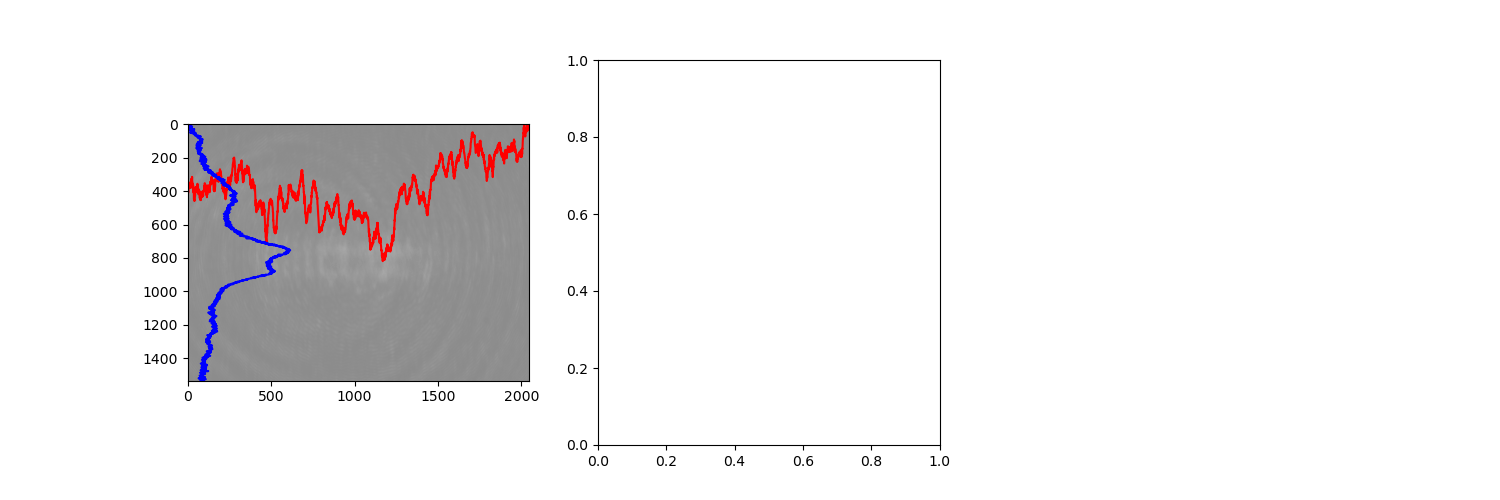

In [93]:
%matplotlib widget

tmp_img = datavol[0,:,:]
lin_vmax = np.max(tmp_img)
sq_vmax = lin_vmax*lin_vmax

nslices = datavol.shape[0]

# Setup for live plot
fig_1 = plt.figure(figsize=(15,5))
f_1A = fig_1.add_subplot(1,3,1)
imgpixels_ref = f_1A.imshow(tmp_img,cmap='gray',vmin=0,vmax=10000)
n_y_px,n_x_px = tmp_img.shape[0],tmp_img.shape[1]
scaling_frac = 0.4

scaled_x_profile = rescale(project("max","X",tmp_img),0,scaling_frac*n_x_px)
scaled_y_profile = rescale(project("max","Y",tmp_img),0,scaling_frac*n_y_px)
xplt, = f_1A.plot(scaled_x_profile,color='r')
#Little fudge to get the plot along y-x, not x-y
yplt, = f_1A.plot(scaled_y_profile,color='b')
newy = yplt.get_xdata()
newx = yplt.get_ydata()
yplt.set_xdata(newx)
yplt.set_ydata(newy)

#Setup for processed plot
f_1B = fig_1.add_subplot(1,3,2)


#Interactions
overlay_proj(fig_1,f_1A,imgpixels_ref,["max","mean"],["r","b"],tmp_img,xplt,yplt)

slicenum = widgets.IntSlider(description="Slice", min=0, max=nslices-1)
gblur_x = widgets.IntSlider(description="Gblur size x", min=1, max=(2*int(datavol.shape[1]/4))+1, step=2)
asp_ratio = widgets.FloatSlider(description="Blur aspect ratio", min = 0.1, max = 1)
run_proc = widgets.Button(description = 'My Button')
square_it = widgets.Checkbox(False, description='Square it')
scale_it = widgets.Checkbox(False, description='Scale to img')
ui = widgets.HBox([slicenum, gblur_x, asp_ratio, square_it, scale_it, run_proc])

def eval_img(img_in):
    return 500

def proc_img(slicenum, gblur_x, asp_ratio, square_it, scale_it):
    slice = datavol[slicenum,:,:]
    gblur_y = int(gblur_x*asp_ratio)
    if(gblur_y%2==0):
        gblur_y = gblur_y+1
    output_image = cv2.GaussianBlur(np.float32(slice), (gblur_x,gblur_y),0,0)#.astype(np.int32)
    if(square_it == True):
        tmp = output_image
        output_image = np.square(tmp)
        imgpixels_ref.set_clim(0,sq_vmax)
    else:
        imgpixels_ref.set_clim(0,lin_vmax)
    if(scale_it == True):
        imgpixels_ref.set_clim(np.min(output_image),np.max(output_image))
    overlay_proj(fig_1,f_1A,imgpixels_ref,["max","mean"],["r","b"],output_image,xplt,yplt)
    return eval_img(output_image)
   
@run_proc.on_click
def dclick(run_proc):
    with alive_bar(nslices,force_tty=True, title = "Processing metric") as metric_progbar:
        metric = []
        for slice in range(nslices):
            metric.append(proc_img(slice, gblur_x.value, asp_ratio.value, square_it.value, scale_it.value))
            metric_progbar()
        f_1B.plot(metric)

out = widgets.interactive_output(proc_img, {'slicenum': slicenum, 'gblur_x': gblur_x, 'asp_ratio': asp_ratio, 'square_it':square_it, 'scale_it':scale_it})
display(ui, out)